# Sommaire

1. **Algorithmes**
   - 1.0 Import des modules
   - 1.1 Génération d'un DAG aléatoire avec attribution d'une caractéristique aléatoire (temps d'exécution)
   - 1.2 Attribution d'un niveau à chaque nœud en fonction de l'ordre topologique pour la visualisation
   - 1.3 Algorithme du Critical Path
   - 1.4 Visualisation du Graph avec alignement des niveaux
   - 1.5 Algorithme greedy scheduling algorithm (GreedyS) avec un ordre topologique
   - 1.6 Algo task schedulling pas de prise en compte du CP mais de coup de communication V1
   - 1.7 Algo task schedulling pas de prise en compte du CP mais de coup de communication V2
   - 1.8 Algo dynamic critical path sans cost com
   - 1.9 Fonction plot schedule
   - 1.10 Fonction qui plot l'ordonnencement de tâches, le makespan, et le graphique d'ordonnancement

2. **Exemples**
    - 2.1 Initialisation des conditions
    - 2.2 Plot du graphe avec les dépendances ainsi que le chemin critique
    - 2.3 Tests des differents algorithmes
        - 2.3.1 Greedy
        - 2.3.2 0 Cp & Cost com V1
        - 2.3.3 0 Cp & Cost com V2
        - 2.3.4 CP & priority

# 1 Algorithmes

### 1.0 Import des modules

In [192]:
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

### I.1 Génération d'un DAG aléatoire avec attribution d'une caractéristique aléatoire (ie temps d'execution d'une tâche)

In [193]:
def generate_random_dag(num_nodes):
    edges = []
    for j in range(1, num_nodes):
        if random.choice([True, False]):
            edges.append((0, j))
    for i in range(1, num_nodes - 1):
        if random.choice([True, False]):
            edges.append((i, num_nodes - 1))
    for i in range(1, num_nodes - 1):
        for j in range(i + 1, num_nodes - 1):
            if random.choice([True, False]):
                edges.append((i, j))
    
    # Généreration d'une caractéristique aléatoire pour chaque nœud
    features = {node: random.randint(1, 10) for node in range(num_nodes)}
    
    return {"nodes": list(range(num_nodes)), "edges": edges, "features": features}

### I.2 Attribue un niveau à chaque nœud en fonction de l'ordre topologique pour la visualisation
Cela nous permet d'aligner les noeuds lors du plot du graphe selon leur profondeur dans le graphe

In [194]:
def assign_subsets(dag):
    """Attribue un niveau `subset` à chaque nœud en fonction de l'ordre topologique."""
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])

    levels = {node: 0 for node in G.nodes}
    for node in nx.topological_sort(G):
        for successor in G.successors(node):
            levels[successor] = max(levels[successor], levels[node] + 1)
    
    return levels

### 1.3 Algorithme du Critical Path
Prend en entrée un graphe et renvoie le chemin critique ainsi que sa distance

In [195]:
def find_critical_path(dag):
    """ Trouve le chemin critique d'un DAG donné """
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])
    
    # Assigner les caractéristiques aux nœuds
    nx.set_node_attributes(G, dag["features"], "feature")
    
    # Calculer les plus longues distances depuis la source
    topological_order = list(nx.topological_sort(G))
    longest_path_length = {node: 0 for node in G.nodes}
    predecessor = {node: None for node in G.nodes}

    for node in topological_order:
        for succ in G.successors(node):
            new_length = longest_path_length[node] + G.nodes[node]["feature"]
            if new_length > longest_path_length[succ]:
                longest_path_length[succ] = new_length
                predecessor[succ] = node

    # Trouver le nœud terminal du chemin critique 
    end_node = max(longest_path_length, key=longest_path_length.get)

    # Reconstruire le chemin critique en remontant depuis le nœud terminal
    critical_path = []
    node = end_node
    while node is not None:
        critical_path.append(node)
        node = predecessor[node]

    return list(reversed(critical_path)), longest_path_length[end_node]

### 1.4 Visualisation du Graph avec alignement des niveaux

In [196]:
def plot_dag(dag):
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])
    
    levels = assign_subsets(dag)
    nx.set_node_attributes(G, levels, "subset")
    nx.set_node_attributes(G, dag["features"], "feature")
    
    pos = nx.multipartite_layout(G, subset_key="subset")
    labels = {node: f"{node}\n{G.nodes[node]['feature']}" for node in G.nodes}
    
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=600, node_color="skyblue", arrowsize=20)
    plt.show()

### 1.5 Algorithme greedy scheduling algorithm (GreedyS) avec un ordre topologique
but : Ordonnancer les tâches sur R ressources pour minimiser le makespan

In [197]:
def GreedyS(dag, num_resources):
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])
    
    # Assigner les caractéristiques (durées) aux nœuds
    nx.set_node_attributes(G, dag["features"], "feature")
    
    # Trier les nœuds par ordre topologique
    topological_order = list(nx.topological_sort(G))
    
    # Temps de fin pour chaque ressource (initialisé à zéro)
    resource_times = [0] * num_resources
    
    # Dictionnaire pour garder une trace des tâches affectées aux ressources
    task_schedule = {}
    
    for node in topological_order:
        # Durée de la tâche
        task_duration = G.nodes[node]["feature"]
        
        # Trouver la ressource qui est disponible le plus tôt
        earliest_available_resource = min(range(num_resources), key=lambda r: resource_times[r])
        
        # Attribuer la tâche à cette ressource
        task_schedule[node] = {
            "resource": earliest_available_resource,
            "start_time": resource_times[earliest_available_resource],
            "end_time": resource_times[earliest_available_resource] + task_duration
        }
        
        # Mettre à jour l'heure de fin de la ressource
        resource_times[earliest_available_resource] += task_duration
    
    # Calculer le makespan (temps total nécessaire)
    makespan = max(resource_times)
    
    return task_schedule, makespan

### 1.6 Algo task schedulling pas de prise en compte du CP mais de coup de communication V1

In [198]:
def zero_CP_costCom_1(dag, num_resources, communication_cost=1):
    """Ordonnancer les tâches sur R ressources en tenant compte des dépendances et du coût de communication."""
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])
    
    nx.set_node_attributes(G, dag["features"], "feature")
    topological_order = list(nx.topological_sort(G))
    resource_times = [0] * num_resources
    task_schedule = {}
    
    # Dictionnaire pour suivre la dernière ressource utilisée pour chaque tâche
    last_resource_used = {}
    
    for node in topological_order:
        task_duration = G.nodes[node]["feature"]
        
        # Vérifier les tâches précédentes pour cette tâche (dépendances)
        earliest_start_time = 0
        for pred in G.predecessors(node):
            earliest_start_time = max(earliest_start_time, task_schedule[pred]["end_time"])
        
        # Trouver la ressource qui est disponible le plus tôt (et gérer les dépendances)
        available_resources = [(r, resource_times[r]) for r in range(num_resources)]
        
        # Appliquer une pénalité sur le changement de ressource
        best_resource = None
        best_start_time = float('inf')
        
        for resource, finish_time in available_resources:
            # Si la ressource a été utilisée précédemment, on applique une pénalité
            resource_penalty = 0
            if resource in last_resource_used and last_resource_used[resource] != node:
                resource_penalty = communication_cost* task_duration  # pénalité pour changement de ressource
            
            # Calculer le temps de début de la tâche sur cette ressource
            start_time = max(finish_time, earliest_start_time) + resource_penalty
            
            # Choisir la ressource avec le temps de début minimal
            if start_time < best_start_time:
                best_start_time = start_time
                best_resource = resource
        
        # Planifier la tâche sur la meilleure ressource
        task_schedule[node] = {
            "resource": best_resource,
            "start_time": best_start_time,
            "end_time": best_start_time + task_duration
        }
        
        # Mettre à jour l'heure de fin de la ressource
        resource_times[best_resource] = task_schedule[node]["end_time"]
        
        # Mémoriser la dernière ressource utilisée pour cette tâche
        last_resource_used[node] = best_resource
    
    # Calculer le makespan (temps total nécessaire)
    makespan = max(resource_times)
    
    return task_schedule, makespan




### 1.7 Algo task schedulling pas de prise en compte du CP mais de coup de communication V2

In [199]:

def zero_CP_costCom_1_V2(dag, num_resources, communication_cost_factor=0.1):
    """Ordonnancer les tâches sur R ressources en minimisant le makespan avec migration des tâches si nécessaire."""
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])
    
    nx.set_node_attributes(G, dag["features"], "feature")
    
    # Calculer le temps d'arrivée (AT) pour chaque tâche en fonction des dépendances
    at = {node: 0 for node in G.nodes}
    for node in nx.topological_sort(G):
        for successor in G.successors(node):
            at[successor] = max(at[successor], at[node] + G.nodes[node]["feature"])
    
    # Temps de disponibilité pour chaque ressource (initialisé à zéro)
    rt = [0] * num_resources  # RT(P_k) pour chaque ressource P_k
    task_schedule = {}
    
    # Dictionnaire pour suivre la dernière ressource utilisée pour chaque tâche
    last_resource_used = {}
    
    # Dictionnaire pour le coût de communication entre les tâches sur différents processeurs
    communication_costs = {node: {successor: communication_cost_factor for successor in G.successors(node)} for node in G.nodes}
    
    for node in nx.topological_sort(G):
        task_duration = G.nodes[node]["feature"]
        earliest_start_time = at[node]
        
        # Chercher la ressource qui minimise FT(t_i, P_k)
        best_resource = None
        best_start_time = float('inf')
        
        for resource in range(num_resources):
            # Calculer FT(t_i, P_k)
            ft = max(earliest_start_time, rt[resource]) + task_duration
            
            # Ajouter le coût de communication si les tâches sont sur des processeurs différents
            if node in last_resource_used and last_resource_used[node] != resource:
                ft += communication_costs[node][last_resource_used[node]]
            
            if ft < best_start_time:
                best_start_time = ft
                best_resource = resource
        
        # Planifier la tâche sur le meilleur processeur
        task_schedule[node] = {
            "resource": best_resource,
            "start_time": best_start_time,
            "end_time": best_start_time + task_duration
        }
        
        # Mettre à jour le temps de disponibilité de la ressource
        rt[best_resource] = task_schedule[node]["end_time"]
        
        # Mémoriser la dernière ressource utilisée pour cette tâche
        last_resource_used[node] = best_resource
        
        # Vérification si migration de tâche est nécessaire pour réduire les échanges
        # Si migration possible sans allonger le makespan, migrer la tâche
        for resource in range(num_resources):
            if resource != best_resource:
                new_ft = max(earliest_start_time, rt[resource]) + task_duration
                if new_ft <= best_start_time:
                    task_schedule[node]["resource"] = resource
                    task_schedule[node]["start_time"] = new_ft
                    task_schedule[node]["end_time"] = new_ft + task_duration
                    rt[resource] = task_schedule[node]["end_time"]
                    last_resource_used[node] = resource
                    break

    # Calculer le makespan (temps total nécessaire)
    makespan = max(rt)
    
    return task_schedule, makespan



### 1.8 Algo dynamic critical path sans cost com

In [200]:
import networkx as nx

def critical_path_schedule_with_priority(dag, num_resources):
    """
    Ordonnancer toutes les tâches sur R ressources en suivant le principe du chemin critique,
    en minimisant le temps de fin (FT) de chaque tâche. Les tâches du chemin critique
    sont traitées en priorité.
    """
    # Créer le graphe à partir des données DAG
    G = nx.DiGraph()
    G.add_nodes_from(dag["nodes"])
    G.add_edges_from(dag["edges"])
    
    # Assigner les caractéristiques (durées) aux nœuds
    nx.set_node_attributes(G, dag["features"], "feature")
    
    # Calculer les plus longues distances depuis la source pour chaque tâche (pour AT)
    topological_order = list(nx.topological_sort(G))
    
    # Initialiser les ressources (processeurs) disponibles
    resource_times = [0] * num_resources
    
    # Dictionnaire pour stocker l'ordonnancement des tâches
    task_schedule = {}
    
    # Liste des tâches restantes
    remaining_tasks = set(G.nodes)
    
    # Calcul du chemin critique
    # Calculer les plus longues distances depuis chaque nœud (calcul de FT et de la durée totale)
    longest_path_length = {}
    for node in topological_order:
        # Pour chaque nœud, on calcule la distance maximale de ses prédécesseurs
        max_pred_time = 0
        for pred in G.predecessors(node):
            max_pred_time = max(max_pred_time, longest_path_length[pred])
        longest_path_length[node] = max_pred_time + G.nodes[node]["feature"]
    
    # Trouver le chemin critique : il s'agit des tâches ayant une durée totale maximale
    critical_path = set()
    max_end_time = max(longest_path_length.values())
    for node in longest_path_length:
        if longest_path_length[node] == max_end_time:
            critical_path.add(node)
            max_end_time -= G.nodes[node]["feature"]
    
    # Liste des tâches à ordonnancer, on commence par celles du chemin critique
    task_order = list(critical_path) + [task for task in topological_order if task not in critical_path]
    
    while remaining_tasks:
        # Sélectionner la tâche avec la plus haute priorité, c'est-à-dire celle du chemin critique ou la suivante
        task_to_schedule = None
        earliest_start_time = float('inf')
        
        for node in task_order:
            if node not in remaining_tasks:
                continue
            # Calculer le temps d'arrivée de la tâche en fonction des dépendances
            earliest_start_time_for_node = 0
            for pred in G.predecessors(node):
                if pred in task_schedule:  # Vérifier si le prédécesseur a déjà été planifié
                    earliest_start_time_for_node = max(earliest_start_time_for_node, task_schedule[pred]["end_time"])
            
            if earliest_start_time_for_node < earliest_start_time:
                earliest_start_time = earliest_start_time_for_node
                task_to_schedule = node
        
        # Calculer le temps d'exécution de la tâche
        task_duration = G.nodes[task_to_schedule]["feature"]
        
        # Trouver le processeur qui sera disponible le plus tôt
        best_processor = min(range(num_resources), key=lambda r: resource_times[r])
        
        # Calculer le temps de fin de la tâche
        start_time = max(earliest_start_time, resource_times[best_processor])
        end_time = start_time + task_duration
        
        # Planifier la tâche
        task_schedule[task_to_schedule] = {
            "resource": best_processor,
            "start_time": start_time,
            "end_time": end_time
        }
        
        # Mettre à jour le temps de disponibilité du processeur
        resource_times[best_processor] = end_time
        
        # Supprimer la tâche de la liste des tâches restantes
        remaining_tasks.remove(task_to_schedule)
    
    # Calculer le makespan (temps total nécessaire)
    makespan = max(resource_times)
    
    return task_schedule, makespan


### 1.9 Fonction plot schedule

In [201]:
def plot_schedule(task_schedule, makespan, num_resources):
    """Affiche l'ordonnancement des tâches."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Créer un graphique de type Gantt
    for task, details in task_schedule.items():
        ax.barh(details["resource"], details["end_time"] - details["start_time"], left=details["start_time"], height=0.8, label=f"Tâche {task}")
    
    ax.set_xlabel("Temps")
    ax.set_ylabel("Ressources")
    ax.set_title(f"Ordonnancement des tâches\nMakespan: {makespan}")
    ax.set_yticks(range(num_resources))
    ax.set_yticklabels([f"Ressource {i}" for i in range(num_resources)])
    plt.tight_layout()
    plt.show()


### 1.10 Fonction qui plot l'ordonnencement de tâches, le makespan, et le graphique d'ordonnancement

In [202]:
def dysplay(task_schedule,makespan):
    print("Ordonnancement des tâches :")
    for task, details in task_schedule.items():
        print(f"Tâche {task} - Ressource {details['resource']}, Début: {details['start_time']}, Fin: {details['end_time']}")
    print(f"Le makespan est: {makespan}")
    # Afficher le graphique de l'ordonnancement
    plot_schedule(task_schedule, makespan, num_resources)

# 2 Exemples

### 2.1 Initialisation des conditions

In [203]:
num_nodes = 15
num_resources = 6 
dag = generate_random_dag(num_nodes)

### 2.2 Plot du graphe avec les dépendances ainsi que le chemin critique

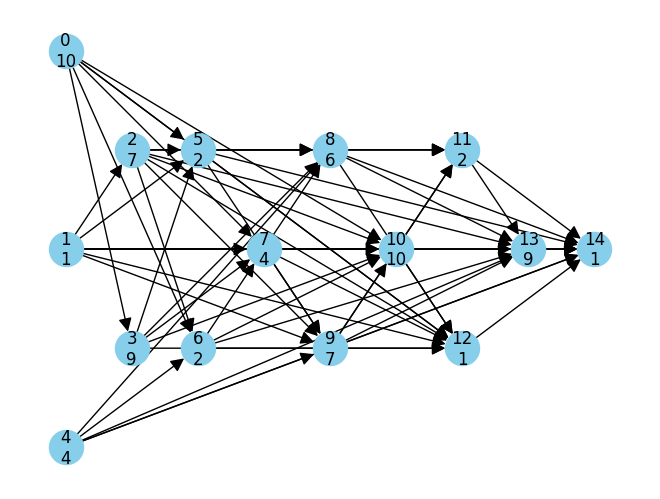

Chemin critique: [0, 3, 7, 9, 10, 11, 13, 14], Longueur: 51


In [204]:
#print(json.dumps(dag, indent=4))
plot_dag(dag)
critical_path, length = find_critical_path(dag)
print(f"Chemin critique: {critical_path}, Longueur: {length}")

### 2.3 Tests des differents algorithmes

##### 2.3.1 Greedy

Ordonnancement des tâches :
Tâche 0 - Ressource 0, Début: 0, Fin: 10
Tâche 1 - Ressource 1, Début: 0, Fin: 1
Tâche 4 - Ressource 2, Début: 0, Fin: 4
Tâche 3 - Ressource 3, Début: 0, Fin: 9
Tâche 2 - Ressource 4, Début: 0, Fin: 7
Tâche 5 - Ressource 5, Début: 0, Fin: 2
Tâche 6 - Ressource 1, Début: 1, Fin: 3
Tâche 7 - Ressource 5, Début: 2, Fin: 6
Tâche 8 - Ressource 1, Début: 3, Fin: 9
Tâche 9 - Ressource 2, Début: 4, Fin: 11
Tâche 10 - Ressource 5, Début: 6, Fin: 16
Tâche 11 - Ressource 4, Début: 7, Fin: 9
Tâche 12 - Ressource 1, Début: 9, Fin: 10
Tâche 13 - Ressource 3, Début: 9, Fin: 18
Tâche 14 - Ressource 4, Début: 9, Fin: 10
Le makespan est: 18


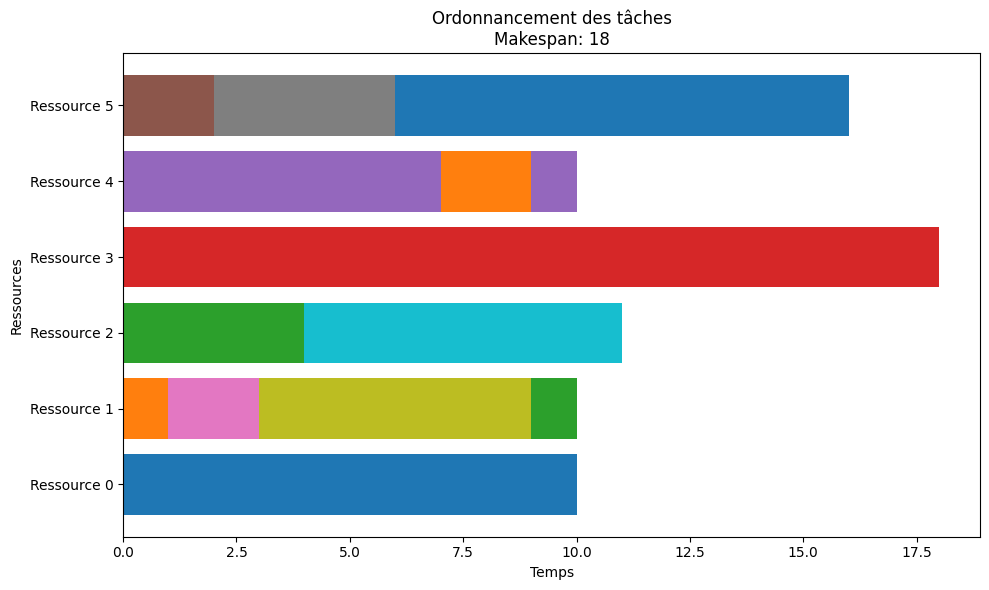

In [205]:
task_schedule_GreedyS, makespan_GreedyS = GreedyS(dag, num_resources)
dysplay(task_schedule_GreedyS,makespan_GreedyS)

##### 2.3.2 0 Cp & Cost com V1

Ordonnancement des tâches :
Tâche 0 - Ressource 0, Début: 0, Fin: 10
Tâche 1 - Ressource 1, Début: 0, Fin: 1
Tâche 4 - Ressource 2, Début: 0, Fin: 4
Tâche 3 - Ressource 2, Début: 10, Fin: 19
Tâche 2 - Ressource 3, Début: 1, Fin: 8
Tâche 5 - Ressource 5, Début: 19, Fin: 21
Tâche 6 - Ressource 0, Début: 12, Fin: 14
Tâche 7 - Ressource 0, Début: 23, Fin: 27
Tâche 8 - Ressource 0, Début: 33, Fin: 39
Tâche 9 - Ressource 1, Début: 34, Fin: 41
Tâche 10 - Ressource 0, Début: 51, Fin: 61
Tâche 11 - Ressource 0, Début: 63, Fin: 65
Tâche 12 - Ressource 1, Début: 62, Fin: 63
Tâche 13 - Ressource 0, Début: 74, Fin: 83
Tâche 14 - Ressource 0, Début: 84, Fin: 85
Le makespan est: 85


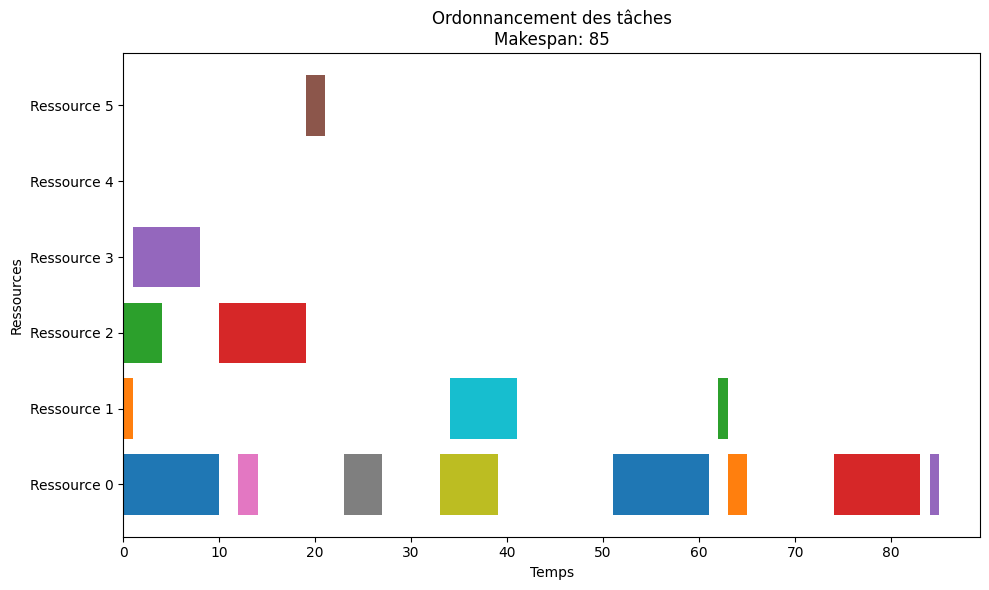

In [206]:
task_schedule_zero_CP_costCom_1, makespan_zero_CP_costCom_1 = zero_CP_costCom_1(dag, num_resources)
dysplay(task_schedule_zero_CP_costCom_1, makespan_zero_CP_costCom_1)


##### 2.3.3 0 Cp & Cost com V2

Ordonnancement des tâches :
Tâche 0 - Ressource 1, Début: 10, Fin: 20
Tâche 1 - Ressource 3, Début: 1, Fin: 2
Tâche 4 - Ressource 5, Début: 4, Fin: 8
Tâche 3 - Ressource 3, Début: 19, Fin: 28
Tâche 2 - Ressource 5, Début: 15, Fin: 22
Tâche 5 - Ressource 1, Début: 22, Fin: 24
Tâche 6 - Ressource 5, Début: 24, Fin: 26
Tâche 7 - Ressource 1, Début: 28, Fin: 32
Tâche 8 - Ressource 5, Début: 32, Fin: 38
Tâche 9 - Ressource 3, Début: 35, Fin: 42
Tâche 10 - Ressource 1, Début: 42, Fin: 52
Tâche 11 - Ressource 5, Début: 42, Fin: 44
Tâche 12 - Ressource 3, Début: 43, Fin: 44
Tâche 13 - Ressource 3, Début: 53, Fin: 62
Tâche 14 - Ressource 5, Début: 52, Fin: 53
Le makespan est: 62


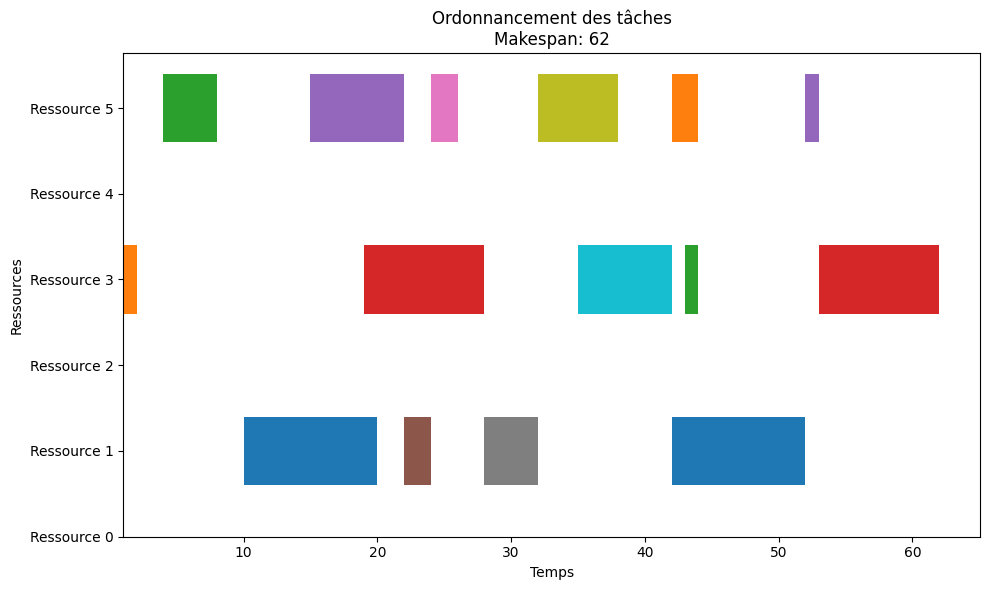

In [207]:
task_schedule_zero_CP_costCom_1_V2, makespan_zero_CP_costCom_1_V2 = zero_CP_costCom_1_V2(dag, num_resources, communication_cost_factor=0.1)
dysplay(task_schedule_zero_CP_costCom_1_V2, makespan_zero_CP_costCom_1_V2)

###### 2.3.4 CP & priority

Ordonnancement des tâches :
Tâche 14 - Ressource 0, Début: 0, Fin: 1
Tâche 0 - Ressource 1, Début: 0, Fin: 10
Tâche 1 - Ressource 2, Début: 0, Fin: 1
Tâche 4 - Ressource 3, Début: 0, Fin: 4
Tâche 11 - Ressource 4, Début: 0, Fin: 2
Tâche 2 - Ressource 5, Début: 1, Fin: 8
Tâche 8 - Ressource 0, Début: 8, Fin: 14
Tâche 9 - Ressource 2, Début: 8, Fin: 15
Tâche 3 - Ressource 4, Début: 10, Fin: 19
Tâche 6 - Ressource 3, Début: 10, Fin: 12
Tâche 13 - Ressource 5, Début: 15, Fin: 24
Tâche 5 - Ressource 1, Début: 19, Fin: 21
Tâche 7 - Ressource 3, Début: 19, Fin: 23
Tâche 10 - Ressource 0, Début: 23, Fin: 33
Tâche 12 - Ressource 2, Début: 33, Fin: 34
Le makespan est: 34


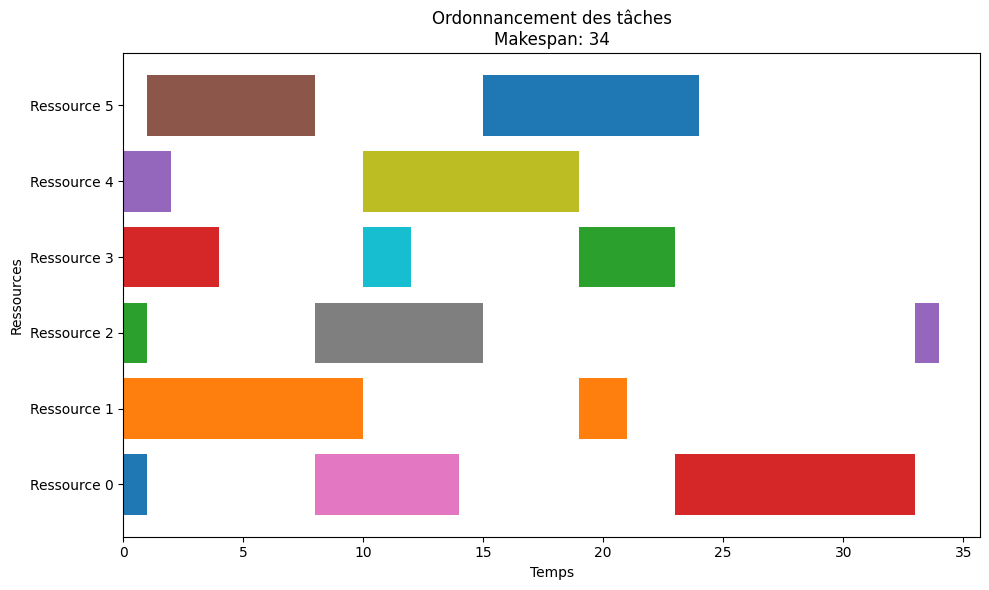

In [208]:
task_schedule_priority, makespan_priority = critical_path_schedule_with_priority(dag, num_resources)
dysplay(task_schedule_priority, makespan_priority)